# Investigate Node-line Intersection Discrepancy
Essentially a cleaner version of `debug stack.ipnb`. Also includes the thresholding based on node SNR derived from the teleseismic events.

In [126]:
using SeisIO, SeisNoise, CSV, Dates, JLD2, HDF5, Glob, Plots, ColorSchemes, Statistics

In [127]:
loadcolorscheme(:cm_maxamp,ColorSchemes.gist_heat.colors[end-50:-1:1], "maxamp color", "for waveform plot");

cm_maxamp overwritten


## Select range of correlations 

In [122]:
VERT_range, B1_range = collect(17:27), collect(53:60)
SVD_VERT = glob("nodes/corr_large/*/*/CI.SVD..NO.B4*","/Volumes/T7/seis_data")
filter!(x -> any(occursin.(["$int" for int in VERT_range],basename(x))), SVD_VERT);

SVD_B1 = glob("nodes/corr_large/*/*/CI.SVD..NO.B11*","/Volumes/T7/seis_data")
filter!(x -> any(occursin.(["$int" for int in B1_range],basename(x)[end-9:end-8])), SVD_B1)

8-element Array{String,1}:
 "/Volumes/T7/seis_data/nodes/corr_large/2019/December/CI.SVD..NO.B1155.--.jld2"
 "/Volumes/T7/seis_data/nodes/corr_large/2019/December/CI.SVD..NO.B1156.--.jld2"
 "/Volumes/T7/seis_data/nodes/corr_large/2019/December/CI.SVD..NO.B1157.--.jld2"
 "/Volumes/T7/seis_data/nodes/corr_large/2019/December/CI.SVD..NO.B1158.--.jld2"
 "/Volumes/T7/seis_data/nodes/corr_large/2019/November/CI.SVD..NO.B1155.--.jld2"
 "/Volumes/T7/seis_data/nodes/corr_large/2019/November/CI.SVD..NO.B1156.--.jld2"
 "/Volumes/T7/seis_data/nodes/corr_large/2019/November/CI.SVD..NO.B1157.--.jld2"
 "/Volumes/T7/seis_data/nodes/corr_large/2019/November/CI.SVD..NO.B1158.--.jld2"

In [76]:
VERT = jld2_corrs(filter(x -> occursin("01", basename(x)), SVD_VERT))
B1 = jld2_corrs(filter(x -> occursin("60", basename(x)), SVD_B1))
println(length(VERT), "  ", length(B1))

37  30


In [77]:
# Make daily correlation plot for Vertical line
name = "B6001"
VERT_daily = plot(title="$name Daily Stacks - Anticausal", legend=false, size=(600,1000), dpi=200,
            xticks = (0:200:1200, -60:10:0), xlabel="Time (s)", ylabel="Amplitude (m)")
for (ind, corr) in enumerate(VERT)
    plot!(VERT_daily, bandpass(corr,0.1,0.35).corr[4800:6000] .+ 0.0005*ind, label = corr.id, linewidth=1)
end
png(VERT_daily,"/Users/julianschmitt/Desktop/SeisPlots2/debug_stack/$(name)_Daily_Stacks_anti.png")
#display(VERT_daily)

In [78]:
# Make daily correlation plot for B1 line
name = "B1260"
B1_daily = plot(title="$name Daily Stacks - Anticausal", legend=false, size=(600,1000), dpi=200,
            xticks = (0:200:1200, -60:10:0), xlabel="Time (s)", ylabel="Amplitude (m)")
for (ind, corr) in enumerate(B1)
    plot!(B1_daily, bandpass(corr,0.1,0.35).corr[4800:6000] .+ 0.0005*ind, label = corr.id, linewidth=1)
end
png(B1_daily,"/Users/julianschmitt/Desktop/SeisPlots2/debug_stack/$(name)_Daily_Stacks_anti.png")
#display(B1_daily)

In [79]:
# Stack Correlations
VERT_stacked = Array{CorrData,1}(undef, 0)
for sta in VERT_range
    VERT_sta = jld2_corrs(filter(x -> occursin("$sta", basename(x)), SVD_VERT))
    if typeof(VERT_sta) ==Array{Any,1}
        continue
    end
    VERT_sta = [elt for elt in VERT_sta if typeof(elt) == CorrData]
    VERT_stack = stack_corrs(VERT_sta)
    push!(VERT_stacked, VERT_stack)
end
B1_stacked = Array{CorrData,1}(undef, 0)
for sta in B1_range
    B1_sta = jld2_corrs(filter(x -> occursin("$sta", basename(x)), SVD_B1))
    if typeof(B1_sta) == Array{Any,1}
        continue
    end
    B1_sta = [elt for elt in B1_sta if typeof(elt) ==CorrData]
    B1_stack = stack_corrs(B1_sta)
    push!(B1_stacked, B1_stack)
end

In [80]:
# Plot full 300 seconds of moveout. 
vert_line = "B6"
B1_and_VERT = plot(title="B1 and $vert_line stacked comparison plot at Intersection: Full", ylabel="Amplitude",
                 xlabel="Time (seconds)", legend=:outertopright, size=(900,450), dpi=200, pad=0.5,
                xticks = (0:60*20:12000, -300:60:300))
for corr in VERT_stacked
    plot!(B1_and_VERT, bandpass(taper(corr), 0.1,0.35).corr, label= corr.name, color="blue")
end
for corr in B1_stacked
    plot!(B1_and_VERT, bandpass(taper(corr), 0.1,0.35).corr, label= corr.name, color="red")
end
png("/Users/julianschmitt/Desktop/SeisPlots2/debug_stack/B1_and_$(vert_line)_intersection_stacked_comparison_noise_uni_color.png")
#display(B1_and_VERT)

In [81]:
# Plot cropped 2 minute window and shiftt stacks
B1_and_VERT = plot(title="B1 and $vert_line stacked comparison plot at Intersection", ylabel="Amplitude",
                 xlabel="Time (seconds)", legend=:outertopright, size=(900,450), dpi=200, pad=0.5,
                xticks = (0:400:2400, -60:20:60))
for corr in VERT_stacked
    plot!(B1_and_VERT, bandpass(taper(corr), 0.1,0.35).corr[4800:7200], label= corr.name)
end
for corr in B1_stacked
    plot!(B1_and_VERT, bandpass(taper(corr), 0.1,0.35).corr[4800:7200] .+ 0.0013, label= corr.name)
end
png("/Users/julianschmitt/Desktop/SeisPlots2/debug_stack/B1_and_$(vert_line)_intersection_stacked_comparison.png")
#display(B1_and_VERT)

### Functions
The following cell defines functions which extract correlations from the larger files, correcly sum an array of `CorrData` objects,  stacks the objects, and mutes noisy correlations.

In [128]:
function jld2_corrs(files::Array{String,1}, key::String = "ZZ")
    ar_corrs = []
    for file in files
        f = jldopen(file,"r")
        corrs = Array{CorrData,1}(undef,0)
        try
            for k in keys(f[key])
                try
                    push!(corrs, f[key][k])
                catch e 
                    println(e)
                end
            end
        catch e 
            println(e)
        end
        close(f)
        push!(ar_corrs, corrs)
    end
    ar = collect(Iterators.flatten(ar_corrs))
    return ar
end
function sum_corrs(corrs::Array{CorrData,1})
    """ Implement sum function on array of corrs before stacking"""
    sum_corr = Array{Float64, 2}(undef, size(corrs[1].corr)[1], length(corrs))
    for (ind, corr) in enumerate(corrs)
        sum_corr[:, ind] = corr.corr[:]
    end
    corr = deepcopy(corrs[1]) # keep metadata from first correlation
    corr.corr = sum_corr # update array of correlations
    return corr
end   
function cc_medianmute(A::AbstractArray, cc_medianmute_α::Float64 = 10.0)
    """
        Remove noisy correlation windows before stacking
        - Remove if average noise is greater than 10x the average
    """
    T, N = size(A)
    cc_maxamp = vec(maximum(abs.(A), dims=1))
    cc_medianmax = median(cc_maxamp)
    inds = findall(x-> x <= cc_medianmute_α*cc_medianmax,cc_maxamp)
    return A[:, inds], inds
end
remove_medianmute(C::CorrData, inds) = (return C.t[inds])
function cc_medianmute!(C::CorrData, cc_medianmute_α::Float64 = 10.0, bool::Bool = true)
    C.corr, inds = cc_medianmute(C.corr, cc_medianmute_α)
    if bool
        C.t = remove_medianmute(C, inds)
    end
    return nothing
end
function stack_corrs(corrs::Array{CorrData,1})
    new_method = sum_corrs(corrs)
    cc_medianmute!(new_method, 3., false)
    SeisNoise.stack!(new_method, allstack=true, stacktype = mean)
    return new_method
end
function bandpass_ar(ar::Array{Float64,2})
    """ Function to quickly bandpass an array for plotting purposes"""
    c = CorrData(corr = ar, fs=20.)
    bandpass!(c, 0.1, 0.35)
    return c.corr
end

stack_corrs (generic function with 1 method)

## Examine a mute for correlations with less signal
As noted in meeting 5/13 there were significantly more day stacks with little signal. We examine the effects of muting those "less coherent" days on the maximum amplitudes of the stacks. 

In [132]:
# Select files
VERT_range, B1_range = collect(17:27), collect(53:60)
SVD_VERT = glob("nodes/corr_large/*/*/CI.SVD..NO.B4*","/Volumes/T7/seis_data")
filter!(x -> any(occursin.(["$int" for int in VERT_range],basename(x))), SVD_VERT);

SVD_B1 = glob("nodes/corr_large/*/*/CI.SVD..NO.B11*","/Volumes/T7/seis_data")
filter!(x -> any(occursin.(["$int" for int in B1_range],basename(x)[end-9:end-8])), SVD_B1)

# Load day stack correlations
VERT = jld2_corrs(filter(x -> occursin("23", basename(x)), SVD_VERT))
B1 = jld2_corrs(filter(x -> occursin("57", basename(x)), SVD_B1))
println(length(VERT), "  ", length(B1))

# Put correlations together in single object
B4_sum = sum_corrs(VERT)
B1_sum = sum_corrs(B1)

35  29


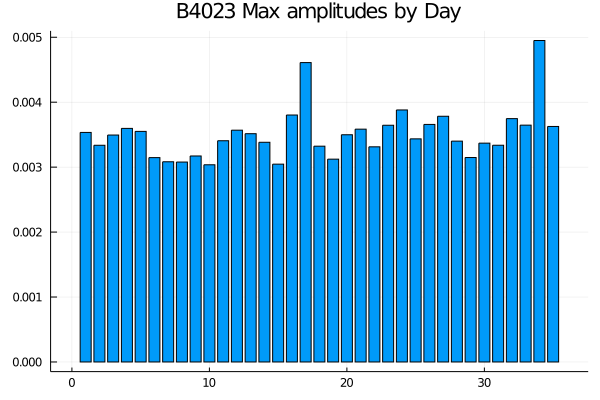

In [160]:
#plot(bandpass_ar(mean(B1_sum.corr, dims=2)))
B1_sum.corr
B1_maxamp = bar(vec(maximum(B1_sum.corr, dims=1)), legend=false, title="B1157 Max amplitudes by Day")
B4_maxamp = bar(vec(maximum(B4_sum.corr, dims=1)), legend=false, title="B4023 Max amplitudes by Day")




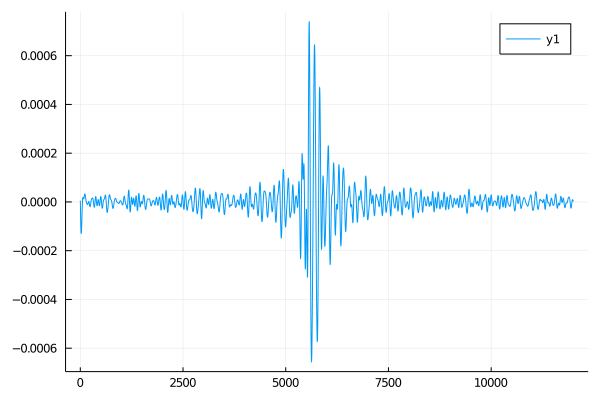

In [149]:
function bandpass_ar(ar::Array{Float64,2})
    c = CorrData(corr = ar, fs=20.)
    bandpass!(c, 0.1, 0.35)
    return c.corr
end
plot(bandpass_ar(mean(B4_sum.corr, dims=2)))


# Explore ratio of components

In [3]:
# open event
using HDF5, Plots
event324 = h5open("/Users/julianschmitt/Downloads/2019_324.h5")
A = read(event324)

┌ Warning: Error requiring `HDF5` from `Plots`
│   exception = (LoadError("/Users/julianschmitt/.julia/packages/Plots/SjqWU/src/backends/hdf5.jl", 162, UndefVarError(:Group)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000010719c11f, Ptr{Nothing} @0x0000000107235eb3, Ptr{Nothing} @0x0000000107236fab, Ptr{Nothing} @0x00000001072358df, Ptr{Nothing} @0x0000000107235bbc, Base.InterpreterIP in top-level CodeInfo for Plots._hdf5_implementation at statement 4, Ptr{Nothing} @0x000000010724f1ce, Ptr{Nothing} @0x000000010724e1b1, Ptr{Nothing} @0x000000010724e9d1, Ptr{Nothing} @0x000000010724f0d6, Ptr{Nothing} @0x0000000107227b6d, Ptr{Nothing} @0x000000010725027c, Ptr{Nothing} @0x00000001151c6d4f, Ptr{Nothing} @0x0000000145d7706e, Ptr{Nothing} @0x0000000107236fcf, Ptr{Nothing} @0x00000001072358df, Ptr{Nothing} @0x0000000107235bbc, Base.InterpreterIP in top-level CodeInfo for Plots at statement 10, Ptr{Nothing} @0x000000010724f1ce, Ptr{Nothing} @0x0000000107250074, Ptr{Nothing} @0x

Dict{String,Any} with 235 entries:
  "B1135" => Dict{String,Any}("Z"=>Float32[3.32534f-7, 8.56808f-7, 1.84767f-6, …
  "B1094" => Dict{String,Any}("Z"=>Float32[7.67393f-6, 7.76019f-6, 8.15461f-6, …
  "B1195" => Dict{String,Any}("Z"=>Float32[3.12787f-5, 3.17368f-5, 3.32009f-5, …
  "B1091" => Dict{String,Any}("Z"=>Float32[-1.32079f-5, -1.37401f-5, -1.47393f-…
  "B1130" => Dict{String,Any}("Z"=>Float32[2.51969f-5, 2.5167f-5, 2.50142f-5, 2…
  "B1003" => Dict{String,Any}("Z"=>Float32[-8.31013f-7, -8.11871f-7, -8.44916f-…
  "B1237" => Dict{String,Any}("Z"=>Float32[0.000167271, 0.00016901, 0.000171609…
  "B1099" => Dict{String,Any}("Z"=>Float32[2.79638f-5, 2.83123f-5, 2.85462f-5, …
  "B1211" => Dict{String,Any}("Z"=>Float32[5.72705f-5, 5.66251f-5, 5.92263f-5, …
  "B1210" => Dict{String,Any}("Z"=>Float32[-3.25794f-5, -3.42447f-5, -3.53164f-…
  "B1123" => Dict{String,Any}("Z"=>Float32[3.76124f-7, -1.05904f-7, -9.08232f-7…
  "B1132" => Dict{String,Any}("Z"=>Float32[-7.91703f-6, -7.16072f-6, 4.006

In [28]:
# get compoents to plot 
Z = A["B1190"]["Z"]
E = A["B1190"]["E"]
N = A["B1190"]["N"];

In [34]:
maximum(abs.(Z))

5.409339f0

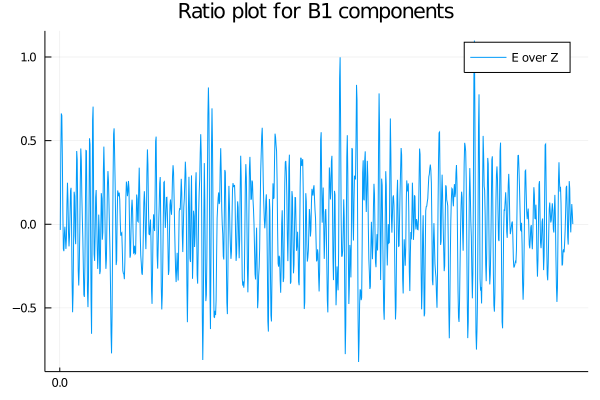

In [38]:
ratio = E -Z
ratio_plot = plot(title= "Ratio plot for B1 components",
            xticks =(0:40*60:length(ratio), 0:1:(length(ratio)/(40*60))))
plot!(ratio_plot,ratio[1000:2000], label="E over Z")
#plot!(ratio_plot, fill(1, 1000), seriestype = :hline, label="Line at 1")

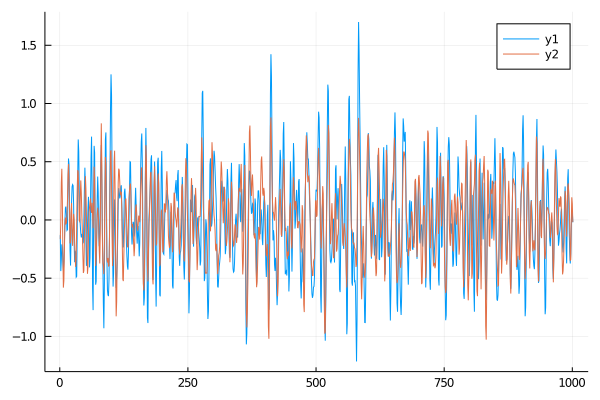

In [36]:
plot(Z[1000:2000]) 
plot!(E[1000:2000]) # overplot

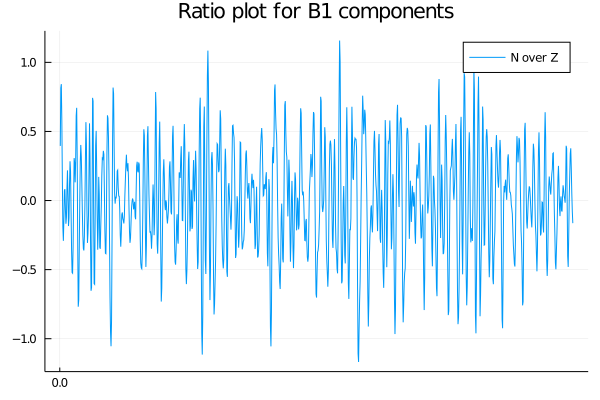

In [42]:
ratio = N -Z
ratio_plot = plot(title= "Ratio plot for B1 components",
            xticks =(0:40*60:length(ratio), 0:1:(length(ratio)/(40*60))))
plot!(ratio_plot,ratio[1000:2000], label="N over Z")
#plot!(ratio_plot, fill(1, 1000), seriestype = :hline, label="Line at 1")

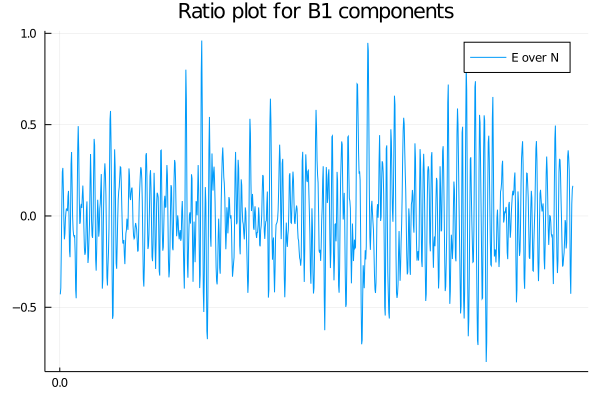

In [43]:
ratio = E -N
ratio_plot = plot(title= "Ratio plot for B1 components",
            xticks =(0:40*60:length(ratio), 0:1:(length(ratio)/(40*60))))
plot!(ratio_plot,ratio[1000:2000], label="E over N")
#plot!(ratio_plot, fill(1, 1000), seriestype = :hline, label="Line at 1")

## Develop Critereon for determining station quality
We threshold SNR values for teleseismic earthquakes. As the deployments were asyncronous, the events are obviously distinct. 

In [63]:
# packages and favorite color scheme
using Glob, CSV, DataFrames, Statistics, ColorSchemes
loadcolorscheme(:cm_maxamp,ColorSchemes.gist_heat.colors[end-30:-1:1], "maxamp color", "for waveform plot");

In [115]:
# first dataframe
df1 = DataFrame(CSV.File(glob("Seismo/laura_snr/*.csv","/Users/julianschmitt/Downloads/")[1]))
head(df1)

6×7 DataFrame
│ Row │ Column1 │ station │ lat     │ lon      │ SNR_R   │ SNR_T   │ SNR_Z   │
│     │ Int64   │ String  │ Float64 │ Float64  │ Float64 │ Float64 │ Float64 │
├─────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────┼─────────┤
│ 1   │ 0       │ B4003   │ 34.1583 │ -117.647 │ 18.9877 │ 9.75418 │ 5.14637 │
│ 2   │ 1       │ B4004   │ 34.1567 │ -117.649 │ 17.2448 │ 11.0859 │ 6.12207 │
│ 3   │ 2       │ B4005   │ 34.1536 │ -117.648 │ 14.9244 │ 22.0702 │ 4.68183 │
│ 4   │ 3       │ B4006   │ 34.1508 │ -117.648 │ 18.9495 │ 12.1931 │ 5.31589 │
│ 5   │ 4       │ B4007   │ 34.1489 │ -117.648 │ 17.9796 │ 16.1694 │ 5.49403 │
│ 6   │ 5       │ B4008   │ 34.1458 │ -117.647 │ 17.4234 │ 16.9548 │ 5.75993 │

In [55]:
# combine all dataframes
all_df = df1
for i in 2:5
    df_new = DataFrame(CSV.File(glob("Seismo/laura_snr/*.csv","/Users/julianschmitt/Downloads/")[i]))
    all_df = vcat(all_df, df_new)

end

In [74]:
# combine dataframes and take mean over identical station names
df=combine(groupby(all_df, :station),:lat, :lon, [:SNR_R, :SNR_T, :SNR_Z] .=>  mean);

In [118]:
# define threshold - play aroud here!
good = Array{Float64, 1}(undef, 0)
for row in eachrow(df)
    if any([row.SNR_R_mean, row.SNR_T_mean, row.SNR_Z_mean] .>=10)
        g = true  
    else 
        g=false
    end
    g = mean([row.SNR_R_mean, row.SNR_T_mean, row.SNR_Z_mean])
    g = min(g, 25.)
    push!(good, g)
end
df.good = good
df

862×7 DataFrame. Omitted printing of 1 columns
│ Row │ station │ lat     │ lon      │ SNR_R_mean │ SNR_T_mean │ SNR_Z_mean │
│     │ String  │ Float64 │ Float64  │ Float64    │ Float64    │ Float64    │
├─────┼─────────┼─────────┼──────────┼────────────┼────────────┼────────────┤
│ 1   │ B4003   │ 34.1583 │ -117.647 │ 18.9877    │ 9.75418    │ 5.14637    │
│ 2   │ B4004   │ 34.1567 │ -117.649 │ 17.2448    │ 11.0859    │ 6.12207    │
│ 3   │ B4005   │ 34.1536 │ -117.648 │ 14.9244    │ 22.0702    │ 4.68183    │
│ 4   │ B4006   │ 34.1508 │ -117.648 │ 18.9495    │ 12.1931    │ 5.31589    │
│ 5   │ B4007   │ 34.1489 │ -117.648 │ 17.9796    │ 16.1694    │ 5.49403    │
│ 6   │ B4008   │ 34.1458 │ -117.647 │ 17.4234    │ 16.9548    │ 5.75993    │
│ 7   │ B4009   │ 34.1433 │ -117.648 │ 10.6489    │ 4.49659    │ 5.38029    │
│ 8   │ B4010   │ 34.1408 │ -117.647 │ 16.5655    │ 22.9869    │ 6.49483    │
│ 9   │ B4011   │ 34.1375 │ -117.648 │ 24.1452    │ 12.8019    │ 7.06989    │
│ 10  │ B4012   │ 34.1358 │ -117.647 │ 12.7128    │ 7.93762    │ 5.28396    │
⋮
│ 852 │ B1252   │ 34.1078 │ -117.322 │ 2.87051    │ 2.56867    │ 3.39487    │
│ 853 │ B1254   │ 34.1075 │ -117.312 │ 1.865      │ 3.23232    │ 3.58698    │
│ 854 │ B1254   │ 34.1075 │ -117.312 │ 1.865      │ 3.23232    │ 3.58698    │
│ 855 │ B1255   │ 34.1075 │ -117.314 │ 4.13352    │ 4.37648    │ 3.99943    │
│ 856 │ B1255   │ 34.1075 │ -117.314 │ 4.13352    │ 4.37648    │ 3.99943    │
│ 857 │ B1257   │ 34.1082 │ -117.306 │ 5.29314    │ 5.57096    │ 6.82679    │
│ 858 │ B1257   │ 34.1082 │ -117.306 │ 5.29314    │ 5.57096    │ 6.82679    │
│ 859 │ B1259   │ 34.1082 │ -117.3   │ 8.36434    │ 4.90138    │ 5.07629    │
│ 860 │ B1259   │ 34.1082 │ -117.3   │ 8.36434    │ 4.90138    │ 5.07629    │
│ 861 │ B1260   │ 34.1076 │ -117.297 │ 7.42749    │ 8.44113    │ 6.67634    │
│ 862 │ B1260   │ 34.1076 │ -117.297 │ 7.42749    │ 8.44113    │ 6.67634    │

In [159]:
# plotting 
df_filt = filter(x -> x.good >=3, df)
ylims = (minimum(df.lat)-0.03, maximum(df.lat)+0.03)
xlims = (minimum(df.lon)-0.03, maximum(df.lon)+0.03)
heatplot= Plots.scatter(df_filt.lon,df_filt.lat, marker_z = df_filt.good, ylims=ylims, xlims=xlims, 
    markerstrokewidth=0, markersize=5, color = :cm_maxamp, colorbar_title="Node quality (Saturates at 25)",
    title="Good vs Bad Nodes: Mean of SNR, threshold at 3", dpi = 200,
    ylabel= "Latitude", xlabel="Longitude", legend=:bottomleft, label="Nodes")
png(heatplot,"/Users/julianschmitt/Desktop/SeisPlots2/threshold_nodes/MEAN_SNR_25_thresh_3.png")